# Imports

In [922]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline
import seaborn as sns
import random
import folium
sns.set_style('whitegrid')

from sklearn.cluster import KMeans

import warnings 
warnings.filterwarnings('ignore')

# Get the data

In [923]:
flight_data = pd.read_csv('Smoothed_data.csv')

In [924]:
flight_data.head()

,Route,Airline,FlightNum,Aircraft,Date,Time,Latitude,Longitude,Course,Kts,mph,feet,Rate,Reporting Facility
0,TLV - ADB,Pegasus Airlines,PC812,A320,18/07/2023,Tue 01:45:23 PM,32.0116,34.8535,← 258°,143.0,165.0,"1,700",,FlightAware ADS-B (LLEK)
1,TLV - ADB,Pegasus Airlines,PC812,A320,18/07/2023,Tue 01:45:39 PM,32.0092,34.8417,← 256°,143.0,165.0,"2,375","2,578",FlightAware ADS-B (LLHS)
2,TLV - ADB,Pegasus Airlines,PC812,A320,18/07/2023,Tue 01:45:55 PM,32.0064,34.8287,← 256°,145.0,167.0,"3,075","2,438",FlightAware ADS-B (TLV / LLBG)
3,TLV - ADB,Pegasus Airlines,PC812,A320,18/07/2023,Tue 01:46:11 PM,32.0036,34.8158,← 256°,156.0,180.0,"3,675","2,063",FlightAware ADS-B (TLV / LLBG)
4,TLV - ADB,Pegasus Airlines,PC812,A320,18/07/2023,Tue 01:46:27 PM,32.0007,34.8023,← 256°,174.0,200.0,"4,175","1,866",FlightAware ADS-B (TLV / LLBG)


In [925]:
flight_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47187 entries, 0 to 47186
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Route               47187 non-null  object 
 1   Airline             47186 non-null  object 
 2   FlightNum           47186 non-null  object 
 3   Aircraft            47186 non-null  object 
 4   Date                47186 non-null  object 
 5   Time                47184 non-null  object 
 6   Latitude            46602 non-null  float64
 7   Longitude           46602 non-null  float64
 8   Course              47184 non-null  object 
 9   Kts                 44873 non-null  float64
 10  mph                 44873 non-null  float64
 11  feet                44805 non-null  object 
 12  Rate                47184 non-null  object 
 13  Reporting Facility  47184 non-null  object 
dtypes: float64(4), object(10)
memory usage: 5.0+ MB


In [926]:
rows_with_nan = flight_data[flight_data['Longitude'].isnull() | flight_data['Latitude'].isnull()]
flight_data.drop(rows_with_nan.index, inplace=True)

In [927]:
flight_data['feet'] = flight_data['feet'].str.replace(',','')
flight_data['Rate'] = flight_data['Rate'].str.replace(',','')

In [928]:
flight_data['feet'] = flight_data['feet'].astype(float)

# Grouping the data

In [929]:
grouped = flight_data.groupby(['Route','Airline','FlightNum','Aircraft','Date']).agg(lambda x: x.tolist()).reset_index()

In [930]:
grouped['Sequence'] = grouped.apply(lambda row: list(zip(row['Latitude'], row['Longitude'])), axis=1)

In [931]:
grouped.drop(['Latitude', 'Longitude','mph','feet','Course','Time','Kts','Rate','Reporting Facility'], axis=1, inplace=True)

In [932]:
grouped

,Route,Airline,FlightNum,Aircraft,Date,Sequence
0,TLV - ADB,Pegasus Airlines,PC812,A320,18/07/2023,"[(32.0116, 34.8535), (32.0092, 34.8417), (32.0..."
1,TLV - ADD,Ethiopian Airlines,ETH415,B38M,17/07/2023,"[(32.0114, 32.01140169), (32.0114, 32.01140877..."
2,TLV - AMM,Royal Jordanian,RJ341,E75L,17/07/2023,"[(32.014, 34.8686), (32.0117, 34.8557), (32.00..."
3,TLV - AMS,El Al,LY337,A320,28/06/2023,"[(32.012, 34.8559), (32.0091, 34.8405), (32.00..."
4,TLV - ARN,Norwegian Air Sweden,NSZ4612,B738,6/7/2023,"[(31.9999, 34.7949), (31.9928, 34.7646), (31.9..."
...,...,...,...,...,...,...
94,TLV - YYZ,Air Canada,AC81,B77L,17/07/2023,"[(32.0142, 32.03822896), (32.01418199, 32.0769..."
95,TLV - ZAG,Croatia Airlines,CTN353,A319,5/7/2023,"[(32.0114, 34.8505), (32.0084, 34.836), (32.00..."
96,TLV - ZNZ,Israir,ISR911,A320,11/7/2023,"[(32.0129, 32.03687511), (32.01288344, 32.0755..."
97,TLV - ZRH,Swiss,LX257,A321,21/07/2023,"[(32.0124, 34.8578), (32.01, 34.8442), (32.006..."


# DTW algorithm to find similarties between every 2 sequences

In [933]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

In [934]:
# import pandas as pd
# import numpy as np

# # Load your grouped DataFrame with 'Route' and 'Sequence' columns
# # Example DataFrame structure:
# # grouped = ...

# def calculate_dtw_distance(sequence1, sequence2):
#     def euclidean_distance(point1, point2):
#         point1_array = np.array(point1)
#         point2_array = np.array(point2)
#         return np.sqrt(np.sum((point1_array - point2_array)**2))
    
#     len_seq1 = len(sequence1)
#     len_seq2 = len(sequence2)
    
#     dtw_matrix = np.zeros((len_seq1 + 1, len_seq2 + 1))
    
#     for i in range(1, len_seq1 + 1):
#         dtw_matrix[i][0] = float('inf')
#     for j in range(1, len_seq2 + 1):
#         dtw_matrix[0][j] = float('inf')
#     dtw_matrix[0][0] = 0
    
#     for i in range(1, len_seq1 + 1):
#         for j in range(1, len_seq2 + 1):
#             cost = euclidean_distance(sequence1[i - 1], sequence2[j - 1])
#             dtw_matrix[i][j] = cost + min(dtw_matrix[i - 1][j], dtw_matrix[i][j - 1], dtw_matrix[i - 1][j - 1])
    
#     dtw_distance = dtw_matrix[len_seq1][len_seq2]
    
#     return dtw_distance


# # Create a new DataFrame to store the DTW distances
# dtw_distances_df = pd.DataFrame(columns=['Route1', 'Route2', 'DTW_Distance'])

# # Iterate through all pairs of routes
# unique_routes = grouped['Route'].unique()
# num_routes = len(unique_routes)

# for i in range(num_routes):
#     for j in range(i + 1, num_routes):
#         route1 = unique_routes[i]
#         route2 = unique_routes[j]
        
#         sequence1 = grouped.loc[grouped['Route'] == route1, 'Sequence'].iloc[0]
#         sequence2 = grouped.loc[grouped['Route'] == route2, 'Sequence'].iloc[0]
        
#         dtw_distance = calculate_dtw_distance(sequence1, sequence2)
        
#         # Print the result
#         print(f"DTW distance between {route1} and {route2}: {dtw_distance}")
        
#         # Add the result to the new DataFrame
#         dtw_distances_df = dtw_distances_df.append({
#             'Route1': route1,
#             'Route2': route2,
#             'DTW_Distance': dtw_distance
#         }, ignore_index=True)


In [935]:
dtw_df = pd.read_csv('dtw_distances_df.csv')

In [936]:
dtw_df

,Route1,Route2,DTW_Distance
0,TLV - ADB,TLV - ADD,1136.630518
1,TLV - ADB,TLV - AMM,917.866083
2,TLV - ADB,TLV - AMS,5194.389155
3,TLV - ADB,TLV - ARN,5033.247195
4,TLV - ADB,TLV - ATH,192.803586
...,...,...,...
4846,TLV - ZAG,TLV - ZRH,700.276740
4847,TLV - ZAG,TLV - ZTH,1045.458591
4848,TLV - ZNZ,TLV - ZRH,9766.920029
4849,TLV - ZNZ,TLV - ZTH,4476.839206


In [937]:
# Get unique route names
unique_routes = np.unique(dtw_df[['Route1', 'Route2']].values)

In [938]:
# Create an NxN distance matrix filled with zeros
n_routes = len(unique_routes)
distance_matrix = np.zeros((n_routes, n_routes))

In [939]:
# Fill the distance matrix using the DTW distances from the DataFrame
for i in range(n_routes):
    for j in range(i, n_routes):
        if i == j:
            distance_matrix[i, j] = 0
        else:
            route1 = unique_routes[i]
            route2 = unique_routes[j]
            dtw_distance = dtw_df[
                ((dtw_df['Route1'] == route1) & (dtw_df['Route2'] == route2)) |
                ((dtw_df['Route1'] == route2) & (dtw_df['Route2'] == route1))
            ]['DTW_Distance'].values[0]
            distance_matrix[i, j] = dtw_distance
            distance_matrix[j, i] = dtw_distance  # Since the matrix is symmetric

In [940]:
# Print the distance matrix
dtw_mat = pd.DataFrame(distance_matrix, index=unique_routes, columns=unique_routes)

In [941]:
dtw_mat

,TLV - ADB,TLV - ADD,TLV - AMM,TLV - AMS,TLV - ARN,TLV - ATH,TLV - ATL,TLV - AUH,TLV - AYT,TLV - BAH,...,TLV - VIE,TLV - VNO,TLV - VRN,TLV - WAW,TLV - YUL,TLV - YYZ,TLV - ZAG,TLV - ZNZ,TLV - ZRH,TLV - ZTH
TLV - ADB,0.000000,1136.630518,917.866083,5194.389155,5033.247195,192.803586,57574.231807,1705.392201,449.211411,983.677518,...,2043.650514,3266.616927,2769.672106,2402.414598,47246.301036,48304.575742,1379.013593,3826.884351,3674.351656,467.391421
TLV - ADD,1136.630518,0.000000,533.985804,8993.627739,8434.520867,1458.960222,64346.637462,532.196506,1000.839572,165.374614,...,4846.016872,6149.383875,5476.014080,4944.327748,55178.599182,55733.778781,3704.688504,2054.981702,6978.814214,1823.187853
TLV - AMM,917.866083,533.985804,0.000000,9470.560575,8651.769808,1337.142063,66732.923833,798.500399,558.668748,362.591996,...,5064.882719,6263.802697,5863.860594,5015.513056,57101.014609,57891.260175,3861.202286,2987.908218,7353.083948,1825.629850
TLV - AMS,5194.389155,8993.627739,9470.560575,0.000000,2593.123684,4623.440985,40913.856171,9576.331253,6755.640327,8860.094160,...,1280.399269,3231.677233,2090.845316,2955.563897,27516.860675,28753.295515,1753.925683,11802.549945,919.761672,4335.730172
TLV - ARN,5033.247195,8434.520867,8651.769808,2593.123684,0.000000,4962.832008,51662.632967,8862.337421,5863.710035,8264.881908,...,2198.830492,1029.886153,3859.929591,856.196762,35483.728957,38945.315168,2930.458481,11431.839594,2844.664591,5013.930809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TLV - YYZ,48304.575742,55733.778781,57891.260175,28753.295515,38945.315168,45821.772245,9831.512499,56452.448974,52146.760514,55669.461266,...,37195.707287,42437.644923,34595.819297,41432.783962,4215.001644,0.000000,37331.076170,57546.167528,31827.009641,43843.089620
TLV - ZAG,1379.013593,3704.688504,3861.202286,1753.925683,2930.458481,1080.026661,47388.480657,4285.325449,2416.489794,3567.264044,...,468.955106,2292.735092,880.453782,1625.219791,36182.162887,37331.076170,0.000000,6548.886938,700.276740,1045.458591
TLV - ZNZ,3826.884351,2054.981702,2987.908218,11802.549945,11431.839594,4131.662439,65872.656531,2469.114960,3641.772571,2651.465146,...,7768.365773,9148.886614,8214.516585,7878.279263,57028.985476,57546.167528,6548.886938,0.000000,9766.920029,4476.839206
TLV - ZRH,3674.351656,6978.814214,7353.083948,919.761672,2844.664591,3111.443862,41909.836614,7583.796357,5065.153913,6850.852393,...,914.495583,2748.631840,1044.860556,2483.791385,31205.749848,31827.009641,700.276740,9766.920029,0.000000,2820.402087


In [942]:
dtw_array = dtw_mat.values

# Clustering

In [943]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import GridSearchCV

In [944]:
cluster_colors = [
    'pink', 'brown', 'yellow', 'orange', 'cyan', 'magenta', 'lime', 'blue',
    'red', 'green', 'purple', 'gold', 'teal', 'indigo', 'salmon', 'olive',
    'orchid', 'navy', 'turquoise', 'plum', 'chocolate', 'crimson', 'darkgreen',
    'darkorchid', 'darkcyan', 'hotpink', 'darkblue', 'darkred', 'darkorange', 'limegreen'
]

# Elbow and Silhouette

In [945]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

In [946]:
max_clusters = 15 

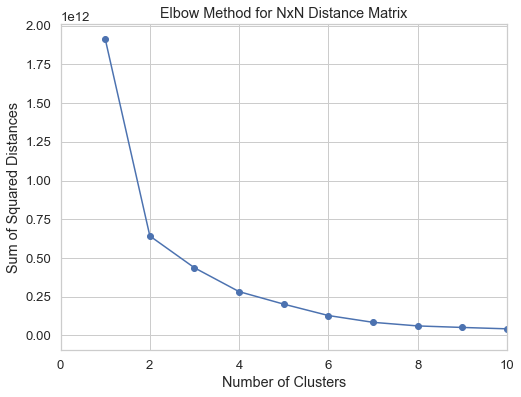

In [947]:
# Calculate the sum of squared distances for each number of clusters
n_clusters_range = range(1, len(dtw_array) + 1)  # Testing for 1 to N clusters
sse = []  # Sum of Squared Errors
for n_clusters in n_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(dtw_array)
    sse.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.xlim(0,10)
plt.plot(n_clusters_range, sse, marker='o')
plt.title('Elbow Method for NxN Distance Matrix')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.show()

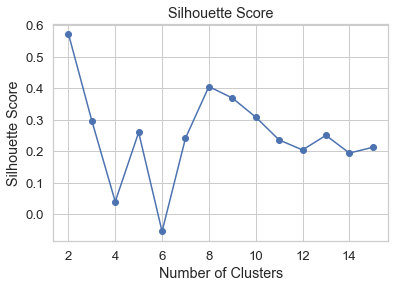

In [988]:
def silhouette_scores(dtw_matrix, max_clusters):
    scores = []
    for num_clusters in range(2, max_clusters + 1):
        _, clusters = kmeans_custom_distance(dtw_matrix, num_clusters)
        labels = np.zeros(dtw_matrix.shape[0], dtype=int)
        for i, cluster in enumerate(clusters):
            labels[cluster] = i
        score = silhouette_score(dtw_matrix, labels, metric='precomputed')
        scores.append(score)
    return scores
max_clusters = 15  # Adjust as needed
sil_scores = silhouette_scores(dtw_matrix, max_clusters)
plt.plot(range(2, max_clusters + 1), sil_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')
plt.show()

# K-means

In [950]:
def custom_distance(point1, point2, dtw_matrix):
    return dtw_matrix[point1, point2]

In [951]:
import numpy as np

def kmeans_custom_distance(dtw_matrix, num_clusters, max_iterations=100):
    num_points = dtw_matrix.shape[0]
    
    # Randomly initialize cluster centroids
    centroids_idx = np.random.choice(num_points, num_clusters, replace=False)
    
    for iteration in range(max_iterations):
        # Assign points to clusters
        clusters = [[] for _ in range(num_clusters)]
        for point_idx in range(num_points):
            distances = [custom_distance(point_idx, centroid_idx, dtw_matrix) for centroid_idx in centroids_idx]
            closest_cluster = np.argmin(distances)
            clusters[closest_cluster].append(point_idx)
        
        # Update centroids
        new_centroids_idx = []
        for cluster_idx in range(num_clusters):
            cluster_points = clusters[cluster_idx]
            if len(cluster_points) > 0:
                # Choose the point with the lowest custom distance as centroid
                distances = [custom_distance(point_idx, point_idx, dtw_matrix) for point_idx in cluster_points]
                new_centroids_idx.append(cluster_points[np.argmin(distances)])
            else:
                # If a cluster becomes empty, reinitialize its centroid randomly
                new_centroids_idx.append(np.random.choice(num_points))
        
        # Check for convergence
        if np.array_equal(centroids_idx, new_centroids_idx):
            break
        
        centroids_idx = new_centroids_idx
    
    return centroids_idx, clusters

In [952]:
# Example usage
np.random.seed(42)  # For reproducibility
N = 99  # Number of sequences
dtw_matrix = dtw_array  # Replace with your actual DTW distance matrix
num_clusters = 7
centroids_idx, clusters = kmeans_custom_distance(dtw_matrix, num_clusters)

In [953]:
print("Cluster centroids:")
print(centroids_idx)
print("\nClusters:")
for i, cluster in enumerate(clusters):
    print(f"Cluster {i}: {cluster}")

Cluster centroids:
[39, 13, 11, 4, 3, 0, 6]

Clusters:
Cluster 0: [39, 43, 62, 66, 70]
Cluster 1: [13, 25, 40]
Cluster 2: [11, 14, 17, 19, 21, 23, 24, 31, 57, 58, 59, 60, 61, 68, 69, 75, 76, 79, 82, 83, 84, 85, 88, 89, 91, 95]
Cluster 3: [4, 12, 27, 37, 49, 72, 90, 92]
Cluster 4: [3, 10, 18, 20, 22, 28, 29, 32, 33, 34, 35, 47, 52, 53, 54, 55, 63, 78, 97]
Cluster 5: [0, 1, 2, 5, 7, 8, 9, 15, 26, 30, 36, 38, 42, 44, 46, 48, 51, 65, 67, 71, 74, 77, 80, 81, 86, 87, 96, 98]
Cluster 6: [6, 16, 41, 45, 50, 56, 64, 73, 93, 94]


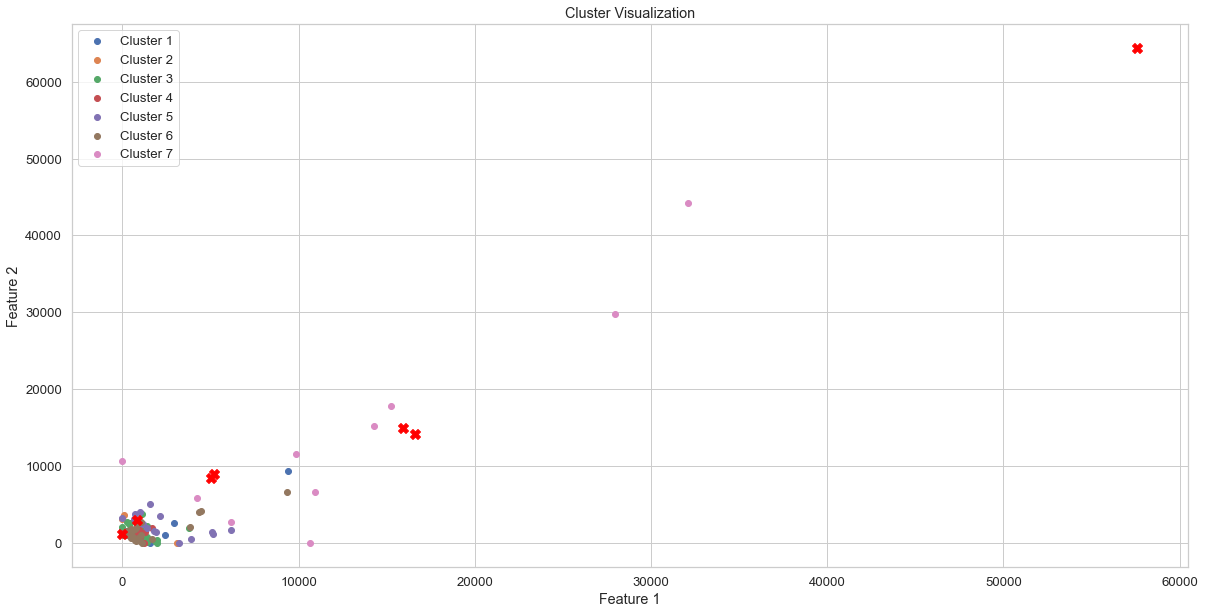

In [954]:
plt.figure(figsize=(20, 10))
for cluster_idx, cluster in enumerate(clusters):
    cluster_points = dtw_matrix[cluster][:, cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_idx + 1}')

# Mark centroids with larger 'X'
for centroid_idx in centroids_idx:
    plt.scatter(dtw_matrix[centroid_idx, 0], dtw_matrix[centroid_idx, 1], marker='X', color='red', s=100)  # Adjust the 's' parameter to control the size

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Cluster Visualization')
plt.legend()
plt.show()

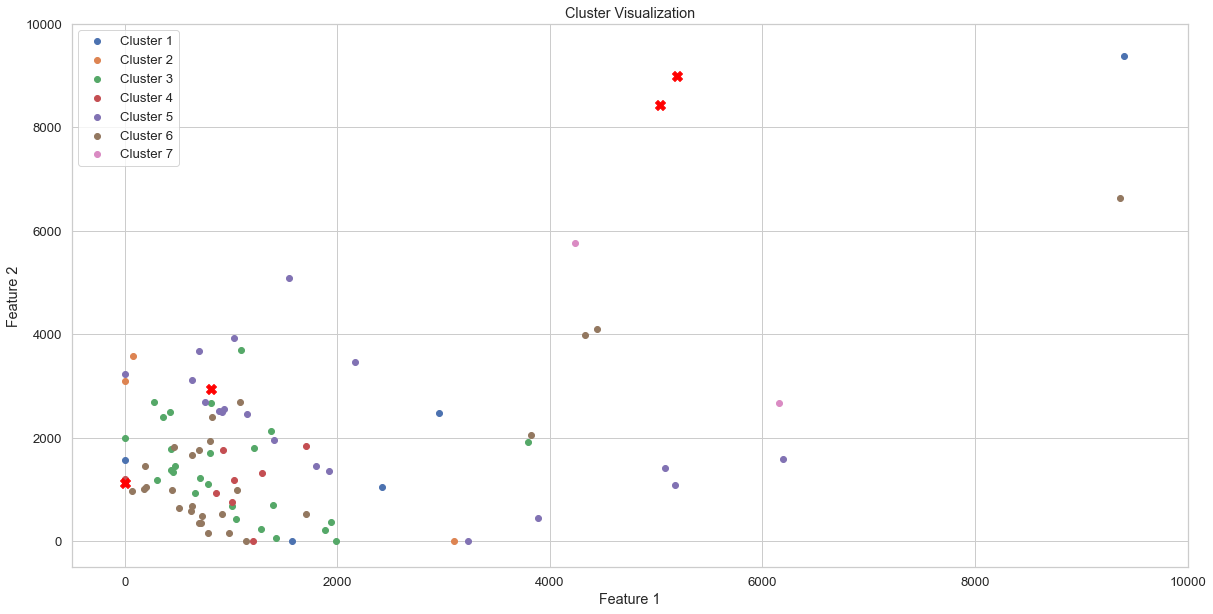

In [955]:
plt.figure(figsize=(20, 10))
for cluster_idx, cluster in enumerate(clusters):
    cluster_points = dtw_matrix[cluster][:, cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_idx + 1}')

# Mark centroids with larger 'X'
for centroid_idx in centroids_idx:
    plt.scatter(dtw_matrix[centroid_idx, 0], dtw_matrix[centroid_idx, 1], marker='X', color='red', s=100)  # Adjust the 's' parameter to control the size

# Set axis limits
plt.xlim(-500, 10000)
plt.ylim(-500, 10000)

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Cluster Visualization')
plt.legend()
plt.show()

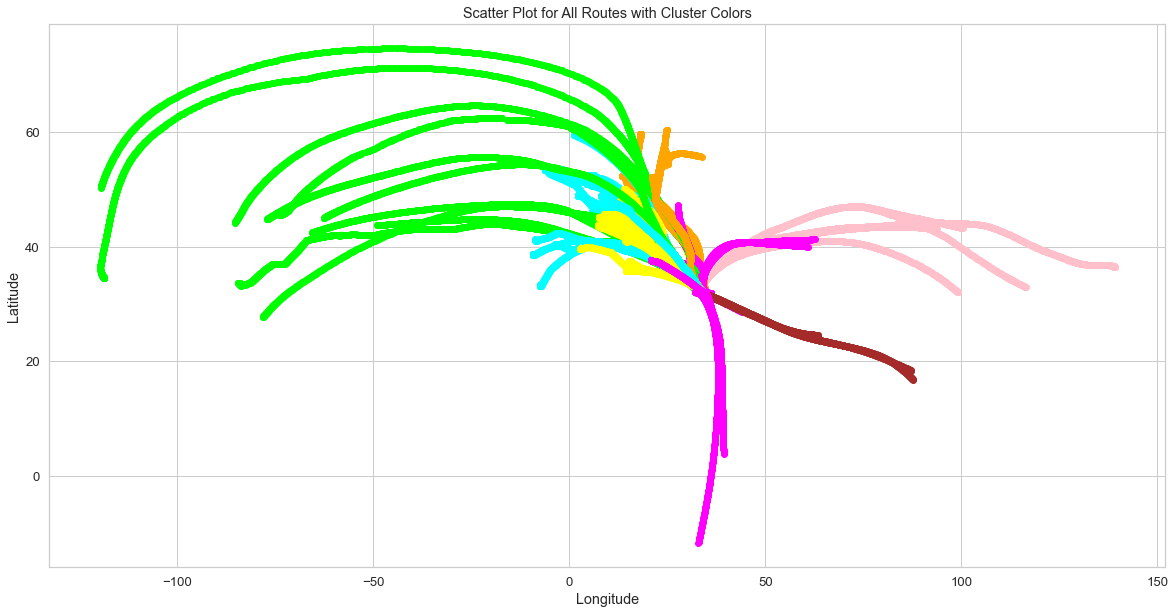

In [956]:
# Create a scatter plot for all routes together
plt.figure(figsize=(20, 10))

for index, row in grouped.iterrows():
    sequence = row['Sequence']
    cluster_label = None
    
    # Find the cluster label for this route
    for i, cluster in enumerate(clusters):
        if index in cluster:
            cluster_label = i
            break

    if cluster_label is not None:
        latitudes = [lat for lat, lon in sequence]
        longitudes = [lon for lat, lon in sequence]
        
        # Scatter points with cluster colors
        plt.scatter(longitudes, latitudes, c=cluster_colors[cluster_label], marker='o', label=f'Cluster {cluster_label}')

plt.title('Scatter Plot for All Routes with Cluster Colors')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

### Kmeans evaluation

In [957]:
def get_cluster_labels(clusters):
    cluster_labels = np.zeros(len(grouped), dtype=int)
    for i, cluster in enumerate(clusters):
        cluster_labels[cluster] = i
    return cluster_labels

# Example usage
cluster_labels = get_cluster_labels(clusters)



silhouette_avg = silhouette_score(dtw_matrix, cluster_labels, metric='precomputed')
print("Silhouette Score:", silhouette_avg)
davies_bouldin = davies_bouldin_score(dtw_matrix, cluster_labels)
print("Davies-Bouldin Index:", davies_bouldin)
ch_score = calinski_harabasz_score(dtw_matrix, cluster_labels)
print("Calinski-Harabasz Index:", ch_score)

Silhouette Score: 0.38464015691373593
Davies-Bouldin Index: 1.1780141105627844
Calinski-Harabasz Index: 61.87663361735091


### Kmeans conclustion

#### We can see that the k-means algorithm knew when the flights were to North America, South Asia, Central Asia and in Europe the algorithm identified that there are 3 types: East Europe, North Europe and West Europe. 
#### The only problem that the algorithm faced is how to cluster the shortest flights and the flights to Africa and he clustered them togther.

# Hierarchical

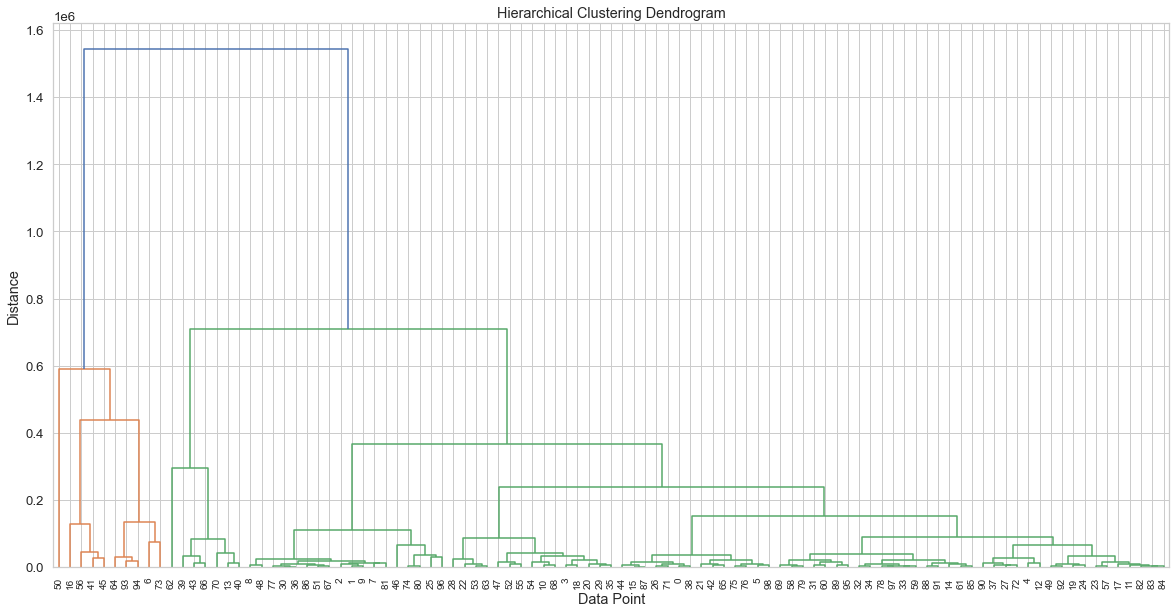

In [958]:
# Compute linkage matrix
linkage_matrix = linkage(dtw_matrix, method='ward')  # Adjust method as needed

# Plot dendrogram
plt.figure(figsize=(20, 10))
dendrogram(linkage_matrix, labels=np.arange(99), leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Point')
plt.ylabel('Distance')
plt.show()

## Hierarchical from scratch

In [959]:
def hierarchical_clustering(dtw_matrix, num_clusters):
    num_points = dtw_matrix.shape[0]
    
    # Initialize each point as its own cluster
    clusters = [[i] for i in range(num_points)]
    
    while len(clusters) > num_clusters:
        min_distance = float('inf')
        merge_indices = None
        
        # Find the two clusters with the closest distance
        for i in range(len(clusters)):
            for j in range(i + 1, len(clusters)):
                cluster1 = clusters[i]
                cluster2 = clusters[j]
                
                # Calculate the distance between clusters using single-linkage
                distance = min(custom_distance(p1, p2, dtw_matrix) for p1 in cluster1 for p2 in cluster2)
                
                if distance < min_distance:
                    min_distance = distance
                    merge_indices = (i, j)
        
        # Merge the two closest clusters
        i, j = merge_indices
        clusters[i].extend(clusters[j])
        del clusters[j]
    
    return clusters

In [960]:
# Example usage
np.random.seed(42)  # For reproducibility
N = 99  # Number of sequences
dtw_matrix = dtw_array  # Replace with your actual DTW distance matrix
num_clusters = 5
clusters = hierarchical_clustering(dtw_matrix, num_clusters)

In [961]:
print("Clusters:")
for i, cluster in enumerate(clusters):
    print(f"Cluster {i}: {cluster}")

Clusters:
Cluster 0: [0, 71, 26, 38, 5, 98, 75, 17, 31, 60, 82, 83, 84, 1, 2, 9, 77, 30, 36, 51, 67, 86, 48, 8, 81, 11, 76, 7, 14, 91, 88, 61, 85, 32, 78, 33, 34, 58, 79, 97, 95, 59, 15, 87, 44, 21, 42, 65, 35, 24, 69, 89, 19, 49, 92, 90, 37, 72, 20, 23, 57, 29, 27, 3, 52, 55, 12, 4, 18, 10, 54, 53, 63, 68, 22, 28, 74, 80, 47, 25, 46, 96, 13, 40, 39, 43, 66, 70, 62]
Cluster 1: [6, 16, 41, 56]
Cluster 2: [45, 94, 93, 64]
Cluster 3: [50]
Cluster 4: [73]


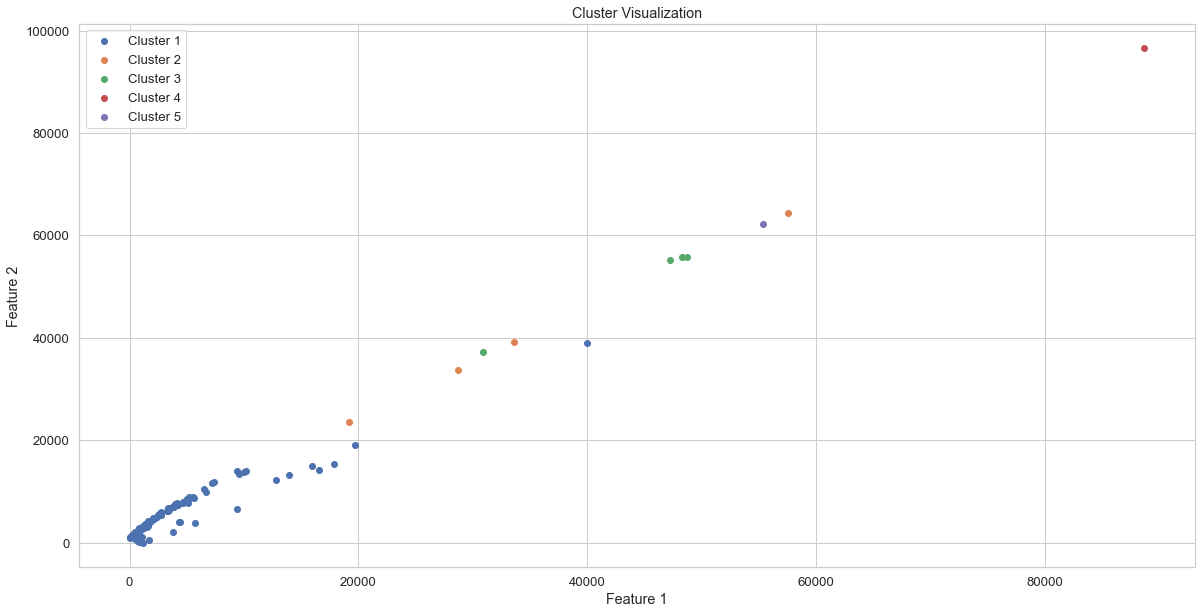

In [962]:
plt.figure(figsize=(20, 10))
for cluster_idx, cluster in enumerate(clusters):
    cluster_points = dtw_matrix[cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_idx + 1}')

# Remove the part that marks centroids since hierarchical clustering doesn't have centroids

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Cluster Visualization')
plt.legend()
plt.show()

Text(0, 0.5, 'Latitude')

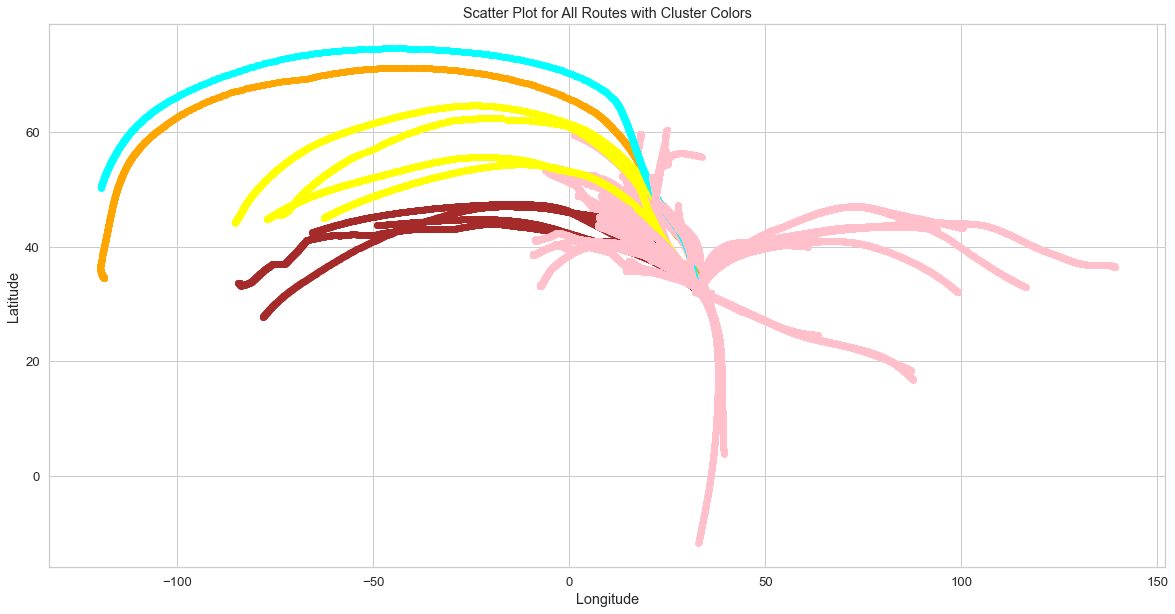

In [963]:
# Create a scatter plot for all routes together
plt.figure(figsize=(20, 10))

for index, row in grouped.iterrows():
    sequence = row['Sequence']
    cluster_label = None
    
    # Find the cluster label for this route
    for i, cluster in enumerate(clusters):
        if index in cluster:
            cluster_label = i
            break

    latitudes = [lat for lat, lon in sequence]
    longitudes = [lon for lat, lon in sequence]
        
    # Scatter points with cluster colors
    plt.scatter(longitudes, latitudes, c=cluster_colors[cluster_label], marker='o', label=f'Cluster {cluster_label}')

plt.title('Scatter Plot for All Routes with Cluster Colors')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

In [964]:
cluster_labels = get_cluster_labels(clusters)

ch_score = calinski_harabasz_score(dtw_matrix, cluster_labels)
print("Calinski-Harabasz Index:", ch_score)
db_score = davies_bouldin_score(dtw_matrix, cluster_labels)
print("Davies-Bouldin Index:", db_score)

Calinski-Harabasz Index: 64.18293576060152
Davies-Bouldin Index: 1.038090834359061


## Hierarchical sklearn

In [965]:
param_grid = {
    'linkage': ['ward', 'complete', 'average', 'single'],
    'affinity': ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']
}

# Create the DBSCAN estimator
hierarchical = AgglomerativeClustering()

In [966]:
grid_search = GridSearchCV(estimator=hierarchical, param_grid=param_grid, cv=5,scoring='neg_mean_squared_error')

In [967]:
grid_search.fit(dtw_array)

GridSearchCV(cv=5, estimator=AgglomerativeClustering(),
             param_grid={'affinity': ['euclidean', 'l1', 'l2', 'manhattan',
                                      'cosine'],
                         'linkage': ['ward', 'complete', 'average', 'single']},
             scoring='neg_mean_squared_error')

In [968]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'affinity': 'euclidean', 'linkage': 'ward'}


In [969]:
hierarchical = AgglomerativeClustering(n_clusters=4,affinity='euclidean', linkage='ward')

In [970]:
cluster_labels = hierarchical.fit_predict(data)

In [971]:
# Dictionary to store data point indices for each cluster
clusters = {}
for idx, label in enumerate(cluster_labels):
    if label not in clusters:
        clusters[label] = [idx]
    else:
        clusters[label].append(idx)

# Printing clusters
print("Clusters:")
for cluster_id, data_indices in clusters.items():
    print(f"Cluster {cluster_id}: {data_indices}")

Clusters:
Cluster 1: [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 42, 44, 46, 47, 48, 49, 51, 52, 53, 54, 55, 57, 58, 59, 60, 61, 63, 65, 67, 68, 69, 71, 72, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 95, 96, 97, 98]
Cluster 0: [6, 16, 41, 45, 56, 64, 73, 93, 94]
Cluster 2: [13, 39, 40, 43, 62, 66, 70]
Cluster 3: [50]


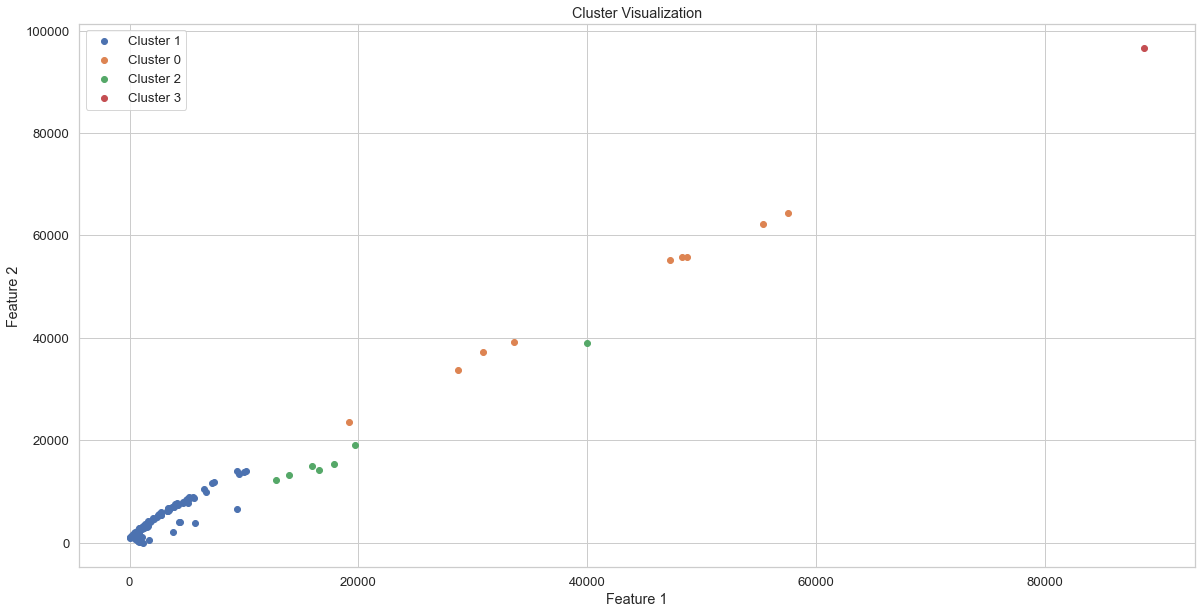

In [972]:
# Assuming you have 'data' as your original dataset
plt.figure(figsize=(20, 10))

for cluster_id, data_indices in clusters.items():
    cluster_points = data[data_indices]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_id}')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Cluster Visualization')
plt.legend()
plt.show()

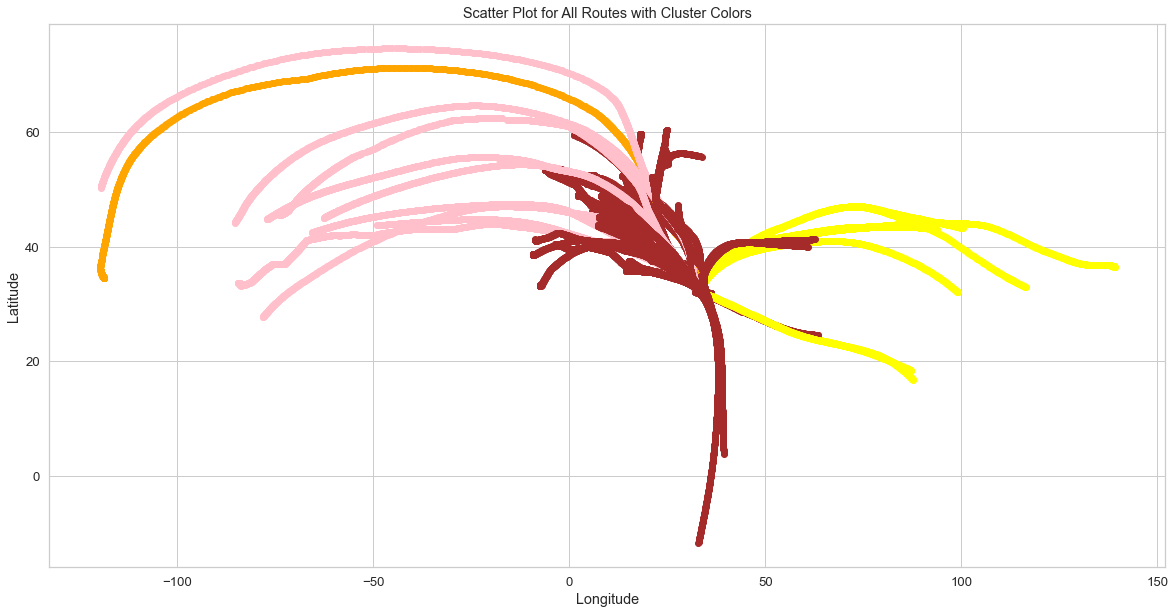

In [973]:
plt.figure(figsize=(20, 10))

for index, row in grouped.iterrows():
    sequence = row['Sequence']
    cluster_label = None
    
    # Find the cluster label for this route
    for i, cluster in clusters.items():
        if index in cluster:
            cluster_label = i
            break

    if cluster_label is not None:
        latitudes = [lat for lat, lon in sequence]
        longitudes = [lon for lat, lon in sequence]
        
        # Scatter points with cluster colors
        plt.scatter(longitudes, latitudes, c=cluster_colors[cluster_label], marker='o', label=f'Cluster {cluster_label}')

plt.title('Scatter Plot for All Routes with Cluster Colors')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

## Hierarchical evalutaion

In [974]:
cluster_labels = get_cluster_labels(clusters)

ch_score = calinski_harabasz_score(dtw_matrix, cluster_labels)
print("Calinski-Harabasz Index:", ch_score)
db_score = davies_bouldin_score(dtw_matrix, cluster_labels)
print("Davies-Bouldin Index:", db_score)

Calinski-Harabasz Index: 0.21449150423407734
Davies-Bouldin Index: 1.5680398083659262


### Hierarchical conclution

### We can see see that the sklearn built algorithm clustered better then the algorithm from scratch.
### The algorithm was not able to cluster the flight to Los Angleas with the rest of North America and he clustered Africa with Europe.

# GMM

In [975]:
np.random.seed(42)
N = 100
data = dtw_array  # Replace with your actual data
num_clusters = 8

In [976]:
param_grid = {
    'n_components': [2, 3, 4, 5],  # Add more values if needed
    'covariance_type': ['full', 'tied', 'diag', 'spherical'],
    'random_state': [42]
}

In [977]:
# Create the GaussianMixture estimator
gmm = GaussianMixture()

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=gmm, param_grid=param_grid, cv=5)

In [978]:
grid_search.fit(data)

GridSearchCV(cv=5, estimator=GaussianMixture(),
             param_grid={'covariance_type': ['full', 'tied', 'diag',
                                             'spherical'],
                         'n_components': [2, 3, 4, 5], 'random_state': [42]})

In [979]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'covariance_type': 'spherical', 'n_components': 5, 'random_state': 42}


In [980]:
gmm = GaussianMixture(covariance_type='spherical', n_components=5, random_state=42)

In [981]:
cluster_labels = gmm.fit_predict(data)

In [982]:
# Dictionary to store data point indices for each cluster
clusters = {}
for idx, label in enumerate(cluster_labels):
    if label not in clusters:
        clusters[label] = [idx]
    else:
        clusters[label].append(idx)

# Printing clusters
print("Clusters:")
for cluster_id, data_indices in clusters.items():
    print(f"Cluster {cluster_id}: {data_indices}")

Clusters:
Cluster 4: [0, 1, 2, 5, 7, 8, 9, 15, 26, 30, 36, 38, 42, 44, 48, 51, 65, 67, 71, 74, 77, 80, 81, 86, 87, 96]
Cluster 0: [3, 4, 10, 11, 12, 14, 17, 18, 19, 20, 21, 22, 23, 24, 27, 28, 29, 31, 32, 33, 34, 35, 37, 47, 49, 52, 53, 54, 55, 57, 58, 59, 60, 61, 63, 68, 69, 72, 75, 76, 78, 79, 82, 83, 84, 85, 88, 89, 90, 91, 92, 95, 97, 98]
Cluster 1: [6, 16, 41, 45, 56, 64, 73, 93, 94]
Cluster 2: [13, 25, 39, 40, 43, 46, 62, 66, 70]
Cluster 3: [50]


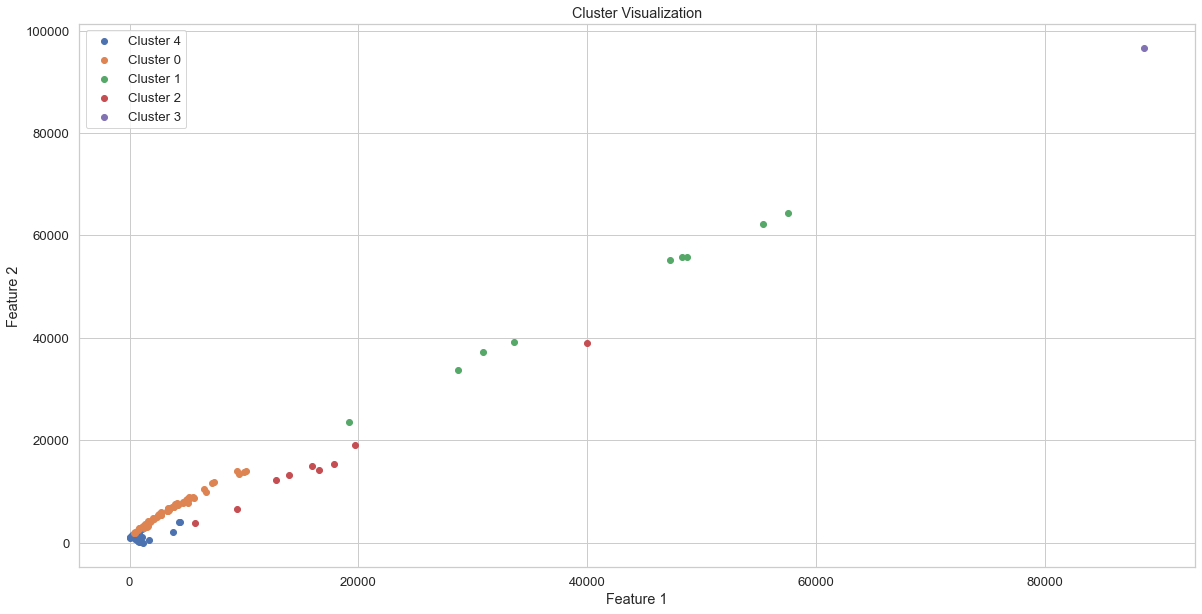

In [983]:
# Assuming you have 'data' as your original dataset
plt.figure(figsize=(20, 10))

for cluster_id, data_indices in clusters.items():
    cluster_points = data[data_indices]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_id}')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Cluster Visualization')
plt.legend()
plt.show()

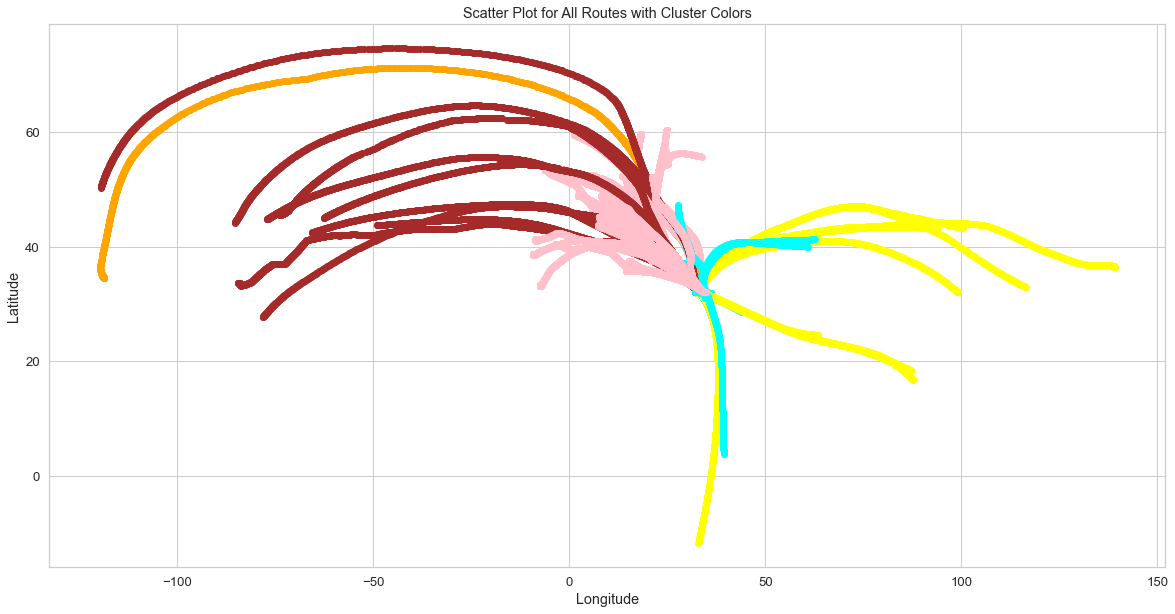

In [984]:
plt.figure(figsize=(20, 10))

for index, row in grouped.iterrows():
    sequence = row['Sequence']
    cluster_label = None
    
    # Find the cluster label for this route
    for i, cluster in clusters.items():
        if index in cluster:
            cluster_label = i
            break

    if cluster_label is not None:
        latitudes = [lat for lat, lon in sequence]
        longitudes = [lon for lat, lon in sequence]
        
        # Scatter points with cluster colors
        plt.scatter(longitudes, latitudes, c=cluster_colors[cluster_label], marker='o', label=f'Cluster {cluster_label}')

plt.title('Scatter Plot for All Routes with Cluster Colors')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

### GMM Evaluation

In [985]:
ch_score = calinski_harabasz_score(dtw_matrix, cluster_labels)
print("Calinski-Harabasz Index:", ch_score)
silhouette_avg = silhouette_score(dtw_matrix, cluster_labels)
print("Silhouette Score:", silhouette_avg)
db_score = davies_bouldin_score(dtw_matrix, cluster_labels)
print("Davies-Bouldin Index:", db_score)

Calinski-Harabasz Index: 165.9754608306224
Silhouette Score: 0.470107132737023
Davies-Bouldin Index: 0.5440412498072282


### GMM Conclution

#### We can see the GMM algorithm did very good clustering apart from the flight to Los Angleas and the flights to africa.